In [1]:
import math
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
import os
import subprocess
from tqdm import trange
from copy import deepcopy

# from dirichlet_actor_critic import Policy
from env_two_step import Scenario, AMoD
from util import mat2str, dictsum, moving_average

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

plt.style.use('ggplot')
CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
# class ReplayBuffer:
#     def __init__(self, capacity):
#         self.capacity = capacity
#         self.buffer = []
#         self.position = 0
    
#     def push(self, state, action, reward, next_state, done):
#         if len(self.buffer) < self.capacity:
#             self.buffer.append(None)
#         self.buffer[self.position] = (state, action, reward, next_state, done)
#         self.position = (self.position + 1) % self.capacity
    
#     def sample(self, batch_size):
#         batch = random.sample(self.buffer, batch_size)
#         state, action, reward, next_state, done = map(np.stack, zip(*batch))
#         return state, action, reward, next_state, done
    
#     def __len__(self):
#         return len(self.buffer)

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done = map(np.stack, zip(*batch))
        return x_ext, x_temp[:, 0], action, reward, next_x_ext, next_x_temp[:, 0], done
    
    def __len__(self):
        return len(self.buffer)

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        
        # initialize affine transformations for neural net
        self.affine1 = nn.Linear(56+16+1, 128)
        self.affine2 = nn.Linear(128, 64)
        self.affine3 = nn.Linear(64, 64)
        
        # initialize GRU cell
        self.rnn = nn.GRU(input_size=56, hidden_size=32, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(1, 1, 32))
        
        # actor's layer
        self.value_head = nn.Linear(96, 1)
        
    def forward(self, x_ext, x_temp):
        x_ext = F.relu(self.affine1(x_ext))
        x_ext = F.relu(self.affine2(x_ext))
        x_ext = F.relu(self.affine3(x_ext))
        
        _, x_temp = self.rnn(x_temp, self.h_0.repeat(1, x_temp.size(0), 1))
        
        h = torch.cat((x_ext.view(-1, 64), x_temp.view(-1, 32)), dim=1)
        x = self.value_head(h)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self):
        super(SoftQNetwork, self).__init__()
        
        # initialize affine transformations for neural net
        self.affine1 = nn.Linear(56+16+1+8, 128)
        self.affine2 = nn.Linear(128, 64)
        self.affine3 = nn.Linear(64, 64)
        
        # initialize GRU cell
        self.rnn = nn.GRU(input_size=56, hidden_size=32, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(1, 1, 32))
        
        # actor's layer
        self.q_head = nn.Linear(96, 1)
        
    def forward(self, x_ext, x_temp, action):
#         print("action: ", action.shape)
        x_ext = torch.cat([x_ext, action.view(x_ext.size(0), 8)], 1)
        x_ext = F.relu(self.affine1(x_ext))
        x_ext = F.relu(self.affine2(x_ext))
        x_ext = F.relu(self.affine3(x_ext))
        
        _, x_temp = self.rnn(x_temp, self.h_0.repeat(1, x_temp.size(0), 1))
        
        h = torch.cat((x_ext.view(-1, 64), x_temp.view(-1, 32)), dim=1)
        x = self.q_head(h)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, env):
        super(PolicyNetwork, self).__init__()
        self.env = env
        # initialize affine transformations for neural net
        self.affine1 = nn.Linear(56+16+1, 128)
        self.affine2 = nn.Linear(128, 64)
        self.affine3 = nn.Linear(64, 64)
        
        # initialize GRU cell
        self.rnn = nn.GRU(input_size=56, hidden_size=32, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(1, 1, 32))
        
        # actor's layer
        self.action_head = nn.Linear(96, 8)
        
    def forward(self, x_ext, x_temp):
        """
        forward of both actor and critic
        """
        x_ext = F.relu(self.affine1(x_ext))
        x_ext = F.relu(self.affine2(x_ext))
        x_ext = F.relu(self.affine3(x_ext))
        
#         print(x_temp.shape)
        _, x_temp = self.rnn(x_temp, self.h_0.repeat(1, x_temp.size(0), 1))
        
        h = torch.cat((x_ext.view(-1, 64), x_temp.view(-1, 32)), dim=1)
        
        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softplus(self.action_head(h)).reshape(-1) + 1e-20
        
        return action_prob
    
    def evaluate(self, x_ext, x_temp, epsilon=1e-6):
        concentrations = self.forward(x_ext, x_temp)
        
        m = Dirichlet(concentrations)

        # and sample an action using the distribution
        action = m.sample() + 1e-16
        
        log_prob = m.log_prob(action) #- torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.sum(-1, keepdim=True)
        
        return action, log_prob, concentrations
        
    
    def get_action(self, state):
        concentrations = self.forward(state[0], state[1])
        
        m = Dirichlet(concentrations)

        # and sample an action using the distribution
        action = m.sample()
        return list(action.numpy())
    
    def get_available_vehicles(self):
        """
        Count total number of available vehicles.
        """
        return np.sum([self.env.acc[region][self.env.time] for region in self.env.region])
    
    def get_desired_distribution(self, action_rl):
        """
        Given a RL action, returns the desired number of vehicles in each area.
        """
        v_d = action_rl*self.get_available_vehicles()
        return list(v_d.numpy())

In [11]:
def soft_q_update(batch_size, 
           gamma=0.99,
           concentrations_lambda=1e-3,
           soft_tau=1e-2,
          ):
    x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done = replay_buffer.sample(batch_size)

    x_ext      = torch.FloatTensor(x_ext).to(device)
    x_temp      = torch.FloatTensor(x_temp).to(device)
    next_x_ext = torch.FloatTensor(next_x_ext).to(device)
    next_x_temp = torch.FloatTensor(next_x_temp).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)
    
#     print("x_ext_update: ", x_ext.shape)
#     print("x_temp_update: ", x_temp.shape)
    expected_q_value = soft_q_net(x_ext, x_temp, action)
    print(f"Expected q value: {expected_q_value.mean()}")
    expected_value   = value_net(x_ext, x_temp)
    new_action, log_prob, concentrations = policy_net.evaluate(x_ext, x_temp)

    target_value = target_value_net(next_x_ext, next_x_temp)
    print(f"Target value: {target_value.mean()}")
    next_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss = soft_q_criterion(expected_q_value, next_q_value.detach())

    expected_new_q_value = soft_q_net(x_ext, x_temp, new_action)
    print(f"Expected new q: {expected_new_q_value.mean()}")
    next_value = expected_new_q_value - log_prob
    value_loss = value_criterion(expected_value, next_value.detach())

    log_prob_target = expected_new_q_value - expected_value
    print(f"Log prob: {log_prob.mean()}")
    policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()
    

#     concentrations_loss = concentrations_lambda * concentrations.pow(2).mean()

#     policy_loss += concentrations_loss

    soft_q_optimizer.zero_grad()
    q_value_loss.backward()
    soft_q_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

In [7]:
# build scenario
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1}, fix_price=True)
env = AMoD(scenario)

In [8]:
value_net        = ValueNetwork().to(device)
target_value_net = ValueNetwork().to(device)

soft_q_net = SoftQNetwork().to(device)
policy_net = PolicyNetwork(env).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer = optim.Adam(soft_q_net.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

### Train model from scratch

In [9]:
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

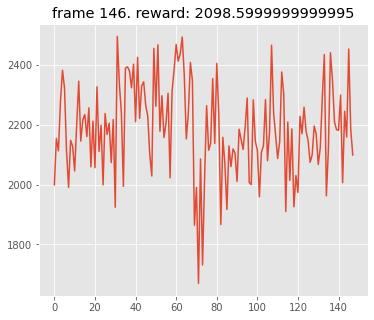


Episode 146 | Reward: 2098.60 | Revenue: 2364.00 | ServedDemand: 278.00 | Reb. Cost: 107.80 | Oper. Cost: 265.40:   0%|          | 146/50000 [1:08:20<403:17:57, 29.12s/it]

Expected q value: -149566.875
Target value: -151788.84375
Expected new q: -148568.765625
Log prob: 6161.07568359375
Expected q value: -151218.109375
Target value: -153633.484375
Expected new q: -150152.890625
Log prob: 6158.0244140625
Expected q value: -155663.703125
Target value: -158257.15625
Expected new q: -154690.21875
Log prob: 6172.2646484375
Expected q value: -139352.96875
Target value: -142444.71875
Expected new q: -138293.34375
Log prob: 6169.37548828125
Expected q value: -143973.4375
Target value: -146956.59375
Expected new q: -142978.015625
Log prob: 6137.66650390625
Expected q value: -148837.15625
Target value: -151486.859375
Expected new q: -147704.96875
Log prob: 6175.37548828125
Expected q value: -135909.40625
Target value: -138750.5625
Expected new q: -134829.203125
Log prob: 6157.21875
Expected q value: -151617.359375
Target value: -154205.25
Expected new q: -150501.71875
Log prob: 6176.380859375
Expected q value: -154684.203125
Target value: -156945.3125
Expected new


Episode 147 | Reward: 1887.60 | Revenue: 2142.00 | ServedDemand: 259.00 | Reb. Cost: 111.60 | Oper. Cost: 254.40:   0%|          | 146/50000 [1:08:49<403:17:57, 29.12s/it]
Episode 147 | Reward: 1887.60 | Revenue: 2142.00 | ServedDemand: 259.00 | Reb. Cost: 111.60 | Oper. Cost: 254.40:   0%|          | 147/50000 [1:08:49<404:03:02, 29.18s/it]

Expected q value: -151801.234375
Target value: -154365.34375
Expected new q: -150827.28125
Log prob: 6155.19287109375
Expected q value: -146423.25
Target value: -148791.671875
Expected new q: -145368.34375
Log prob: 6174.12744140625
Expected q value: -136314.65625
Target value: -138848.765625
Expected new q: -135114.09375
Log prob: 6186.44091796875
Expected q value: -151014.6875
Target value: -153294.1875
Expected new q: -150060.515625
Log prob: 6168.181640625
Expected q value: -144232.875
Target value: -146386.328125
Expected new q: -143175.5
Log prob: 6175.07275390625
Expected q value: -151708.609375
Target value: -153609.1875
Expected new q: -150610.4375
Log prob: 6164.30029296875
Expected q value: -152805.75
Target value: -154476.890625
Expected new q: -151705.546875
Log prob: 6163.0517578125
Expected q value: -148572.28125
Target value: -150344.453125
Expected new q: -147484.921875
Log prob: 6146.3251953125
Expected q value: -153086.4375
Target value: -154918.78125
Expected new q:


Episode 148 | Reward: 2306.60 | Revenue: 2574.00 | ServedDemand: 324.00 | Reb. Cost: 95.80 | Oper. Cost: 267.40:   0%|          | 147/50000 [1:09:15<404:03:02, 29.18s/it] 
Episode 148 | Reward: 2306.60 | Revenue: 2574.00 | ServedDemand: 324.00 | Reb. Cost: 95.80 | Oper. Cost: 267.40:   0%|          | 148/50000 [1:09:15<388:44:36, 28.07s/it]

Expected q value: -157749.671875
Target value: -159754.5
Expected new q: -156761.96875
Log prob: 6177.888671875
Expected q value: -155304.171875
Target value: -156949.21875
Expected new q: -154328.171875
Log prob: 6155.91357421875
Expected q value: -146883.4375
Target value: -148609.65625
Expected new q: -145782.625
Log prob: 6171.7939453125
Expected q value: -154429.796875
Target value: -156725.8125
Expected new q: -153480.796875
Log prob: 6166.16650390625
Expected q value: -142767.625
Target value: -145045.109375
Expected new q: -141712.25
Log prob: 6158.5712890625
Expected q value: -138445.453125
Target value: -140806.953125
Expected new q: -137461.515625
Log prob: 6176.5498046875
Expected q value: -150580.59375
Target value: -152745.09375
Expected new q: -149562.0
Log prob: 6161.8896484375
Expected q value: -155821.734375
Target value: -157848.390625
Expected new q: -154679.21875
Log prob: 6150.18408203125
Expected q value: -146353.5
Target value: -148538.65625
Expected new q: -145


Episode 149 | Reward: 2253.00 | Revenue: 2520.00 | ServedDemand: 312.00 | Reb. Cost: 99.00 | Oper. Cost: 267.00:   0%|          | 148/50000 [1:09:43<388:44:36, 28.07s/it]
Episode 149 | Reward: 2253.00 | Revenue: 2520.00 | ServedDemand: 312.00 | Reb. Cost: 99.00 | Oper. Cost: 267.00:   0%|          | 149/50000 [1:09:43<387:58:00, 28.02s/it]

Expected q value: -141563.015625
Target value: -144054.0625
Expected new q: -140479.484375
Log prob: 6166.6533203125
Expected q value: -145735.25
Target value: -148480.171875
Expected new q: -144645.09375
Log prob: 6121.55615234375
Expected q value: -147775.25
Target value: -150589.9375
Expected new q: -146833.25
Log prob: 6162.6904296875
Expected q value: -150357.21875
Target value: -153249.5625
Expected new q: -149353.234375
Log prob: 6166.19140625
Expected q value: -149760.59375
Target value: -152478.8125
Expected new q: -148714.34375
Log prob: 6169.3515625
Expected q value: -154832.6875
Target value: -157389.015625
Expected new q: -153845.78125
Log prob: 6170.67578125
Expected q value: -154212.25
Target value: -156730.59375
Expected new q: -153153.546875
Log prob: 6159.24658203125
Expected q value: -149336.1875
Target value: -151945.109375
Expected new q: -148427.484375
Log prob: 6150.71923828125
Expected q value: -152473.9375
Target value: -154545.640625
Expected new q: -151405.06

In [12]:
# book-keeping variables
training_rewards = []
training_revenue = []
training_served_demand = []
training_rebalancing_cost = []
training_operating_cost = []

# last_t_update = 0
train_episodes = 50000 # num_of_episodes_with_same_epsilon x num_of_q_tables x num_epsilons          
max_steps = 100 # maximum length of episode
epochs = trange(train_episodes) # build tqdm iterator for loop visualization

for i_episode in epochs:
    try:
        obs = env.reset()
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        for step in range(max_steps):
            # take matching step 
            obs, paxreward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="SAC/v1/")
            episode_reward += paxreward
            # Select and perform an RL action
            x_ext = torch.tensor([obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            state = (x_ext, x_temp)
            action_rl = policy_net.get_action(state)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = policy_net.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/SAC/v1/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            # Take step
            new_obs, rebreward, done, info = env.reb_step(rebAction)
            episode_reward += rebreward
            x_ext = torch.tensor([new_obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            new_state = (x_ext, x_temp)

            # Store the transition in memory
            replay_buffer.push(state[0].numpy(), state[1].numpy(), np.array(action_rl), paxreward + rebreward, new_state[0].numpy(), new_state[1].numpy(), done)
            
            if len(replay_buffer) > batch_size:
                soft_q_update(batch_size)
                
            # Move to the next state
            # track performance over episode
            episode_revenue += info['revenue']
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            obs, state = deepcopy(new_obs), deepcopy(new_state)
            
            
            if done:
                break
        
        epochs.set_description(f"Episode {i_episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost:.2f} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        training_rewards.append(episode_reward)
        training_revenue.append(episode_revenue)
        training_served_demand.append(episode_served_demand)
        training_rebalancing_cost.append(episode_rebalancing_cost)
        training_operating_cost.append(episode_operating_cost)
        
        if i_episode % 5 == 0:
            plot(i_episode+1, training_rewards)
            
    except KeyboardInterrupt:
        break

In [9]:
batch = random.sample(replay_buffer.buffer, batch_size)

In [10]:
x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done = map(np.stack, zip(*batch))

In [12]:
x_temp[:, 0].shape

(128, 10, 56)

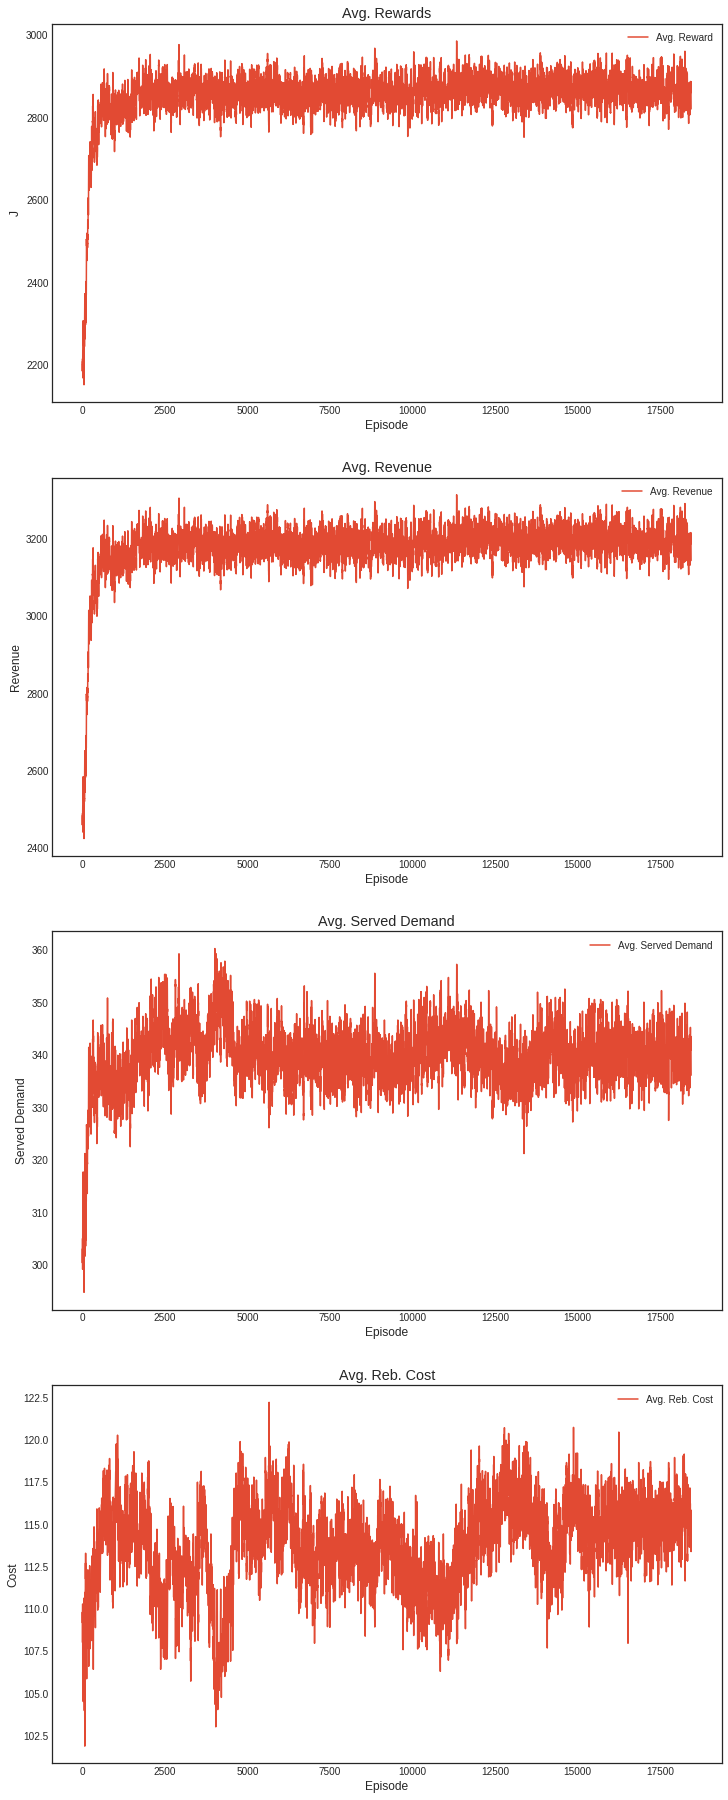

In [22]:
# Plot results with moving average smoothing 
plt.style.use("seaborn-white")
fig = plt.figure(figsize=(12,32))
fig.add_subplot(411)
plt.plot(moving_average(training_rewards, n=10), label="Avg. Reward")
plt.title("Avg. Rewards")
plt.xlabel("Episode")
plt.ylabel("J")
plt.legend()

fig.add_subplot(412)
plt.plot(moving_average(training_revenue, n=10), label="Avg. Revenue")
plt.title("Avg. Revenue")
plt.xlabel("Episode")
plt.ylabel("Revenue")
plt.legend()

fig.add_subplot(413)
plt.plot(moving_average(training_served_demand, n=10), label="Avg. Served Demand")
plt.title("Avg. Served Demand")
plt.xlabel("Episode")
plt.ylabel("Served Demand")
plt.legend()

fig.add_subplot(414)
plt.plot(moving_average(training_rebalancing_cost, n=10), label="Avg. Reb. Cost")
plt.title("Avg. Reb. Cost")
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.legend()
plt.show()

### Test

In [27]:
# three levels
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1}, fix_price=True) # uni-directional
env = AMoD(scenario)
model.env = env

In [28]:
from tqdm import trange

test_episodes = 100
max_steps = 100
epochs = trange(test_episodes) # build tqdm iterator for loop visualization
np.random.seed(10)

test_rewards = []
test_revenue = []
test_served_demand = []
test_rebalancing_cost = []
test_operating_cost = []
action_list = []

for episode in epochs:
    try:
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        episode_action_list = []
        obs = env.reset()
        done = False
        while(not done):
            # take matching step 
            obs, paxreward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="AC/v9/")
            episode_reward += paxreward
            # Select and perform an RL action
            x_ext = torch.tensor([obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            state = (x_ext, x_temp)
            with torch.no_grad():
                c, _ = model(state[0], state[1])
                action_rl = list(c.numpy()/c.numpy().sum())
            episode_action_list.append(action_rl)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = model.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/AC/v9/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            new_obs, rebreward, done, info = env.reb_step(rebAction)
            episode_reward += rebreward
            x_ext = torch.tensor([new_obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            new_state = (x_ext, x_temp)
            
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            episode_revenue += info['revenue']
        epochs.set_description(f"Episode {episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        test_rewards.append(episode_reward)
        test_revenue.append(episode_revenue)
        test_served_demand.append(episode_served_demand)
        test_rebalancing_cost.append(episode_rebalancing_cost)
        test_operating_cost.append(episode_operating_cost)
        action_list.append(episode_action_list)
        break
    except KeyboardInterrupt:
        break





  0%|          | 0/100 [00:00<?, ?it/s]



Episode 1 | Reward: 2728.60 | Revenue: 3039.00 | ServedDemand: 318.00 | Reb. Cost: 107.8 | Oper. Cost: 310.40:   0%|          | 0/100 [00:05<?, ?it/s]